In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [43]:
# Load training and test datasets
df_train = pd.read_csv("./data/fraudTrain.csv")
df_test = pd.read_csv("./data/fraudTest.csv")

In [44]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return R * c


In [45]:
def preprocess(df):
    """
    Feature Engineering Phase (potenziata):
     - Calcola età, ora, giorno
     - Flag su notte/weekend
     - Distanza utente-merchant (haversine)
     - Log-transform per variabili skewed
     - Statistiche utente (media/frequenza)
     - Rimozione colonne inutili
    """

    df = df.copy()

    # Date parsing
    df['dob'] = pd.to_datetime(df['dob'])
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Età in anni
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # Tempo
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x >= 22 else 0)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Distanza geografica tra utente e merchant
    df['distance_user_to_merch'] = df.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
        axis=1
    )

    # Log-transform di variabili skewed
    df['log_amt'] = np.log1p(df['amt'])
    df['log_city_pop'] = np.log1p(df['city_pop'])
    df['log_distance'] = np.log1p(df['distance_user_to_merch'])

    # Statistiche user-based
    df['user_id'] = df['cc_num'].astype(str)  # User proxy

    # Numero di transazioni passate per utente (fino a quel punto)
    df.sort_values(['user_id', 'trans_date_trans_time'], inplace=True)
    df['tx_count_user'] = df.groupby('user_id').cumcount()

    # Media mobile dell’importo (fino a quel punto)
    df['amt_mean_user'] = df.groupby('user_id')['amt'].transform(lambda x: x.rolling(10, min_periods=1).mean())

    # Rimozione colonne inutili
    df = df.drop(columns=[
        'trans_date_trans_time', 'dob', 'first', 'last', 'street',
        'trans_num', 'cc_num',  # rimosso cc_num perché usato solo per aggregare
        'amt', 'city_pop', 'distance_user_to_merch'  # rimpiazzati con log versions
    ])

    return df

In [46]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [47]:
# Colonne categoriche (rimangono invariate)
categorical_cols = ['gender', 'category', 'state', 'job']

# Colonne numeriche aggiornate
numeric_cols = [
    'age', 'hour', 'day_of_week',
    'is_night', 'is_weekend',
    'log_amt', 'log_city_pop', 'log_distance',
    'tx_count_user', 'amt_mean_user'
]

# Colonna target (rimane invariata)
target_col = 'is_fraud'


In [48]:
# Standardizes numeric columns and transforms categorical columns in One Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [49]:
import torch

# Check if GPU usage is available
print(torch.cuda.is_available()) 

True


In [50]:
# Define train and test columns
X_train = df_train[categorical_cols + numeric_cols]
y_train = df_train[target_col]

X_test = df_test[categorical_cols + numeric_cols]
y_test = df_test[target_col]

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [52]:
# Pipeline con preprocessor e XGBClassifier con impostazioni GPU
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # il tuo preprocessore già definito
    ('clf', XGBClassifier(
        eval_metric='logloss', # Logarithmic Loss Function for Binary Classification
        random_state=42,
        verbosity=1
    ))
])

In [53]:
# Hyperparameters for XGBClassifier
param_grid = {
    'clf__n_estimators': [200],
    'clf__max_depth': [12],
    'clf__learning_rate': [0.2],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [1.0],
    'clf__scale_pos_weight': [10],
    'clf__reg_alpha': [0, 1],  
    'clf__reg_lambda': [1, 10],  

}

# Cross-Validation with 3 folds 
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define Grid Search for training phase using F1-Score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=2
)

# Training phase
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.2, 'clf__max_depth': 12, 'clf__n_estimators': 200, 'clf__reg_alpha': 1, 'clf__reg_lambda': 10, 'clf__scale_pos_weight': 10, 'clf__subsample': 0.8}
Best F1 score: 0.9292565947242206


In [54]:
# Probabilistic predictions
y_proba = best_model.predict_proba(X_test)[:, 1]

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.92      0.87      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.96      0.94    555719
weighted avg       1.00      1.00      1.00    555719



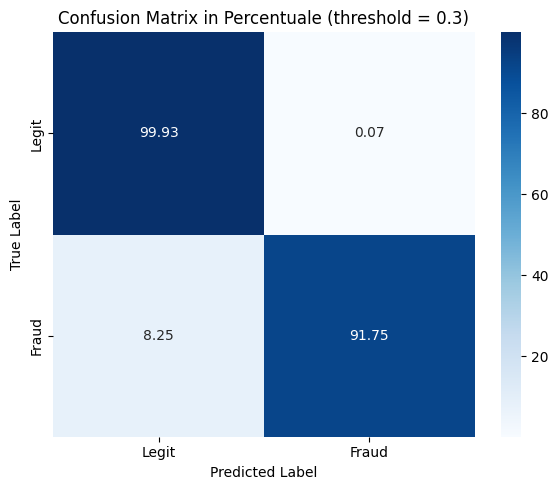

In [56]:
# Threshold personalizzato (es: 0.3)
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Report e confusion matrix
print(classification_report(y_test, y_pred, digits=2))

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # percentuale per riga

# Plot della confusion matrix in percentuale
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix in Percentuale (threshold = {threshold})")
plt.tight_layout()
plt.show()

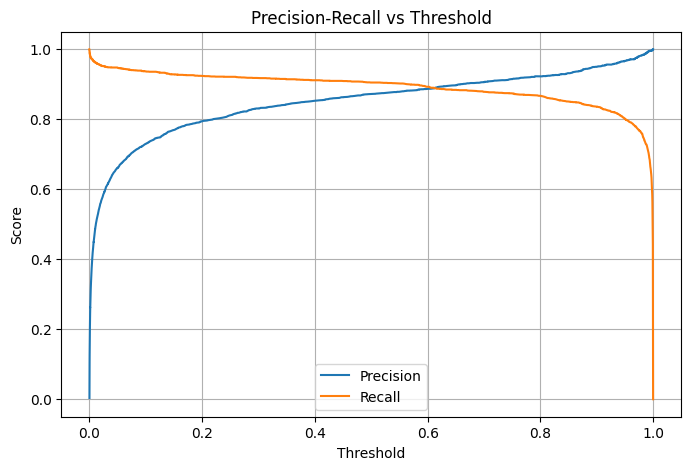

In [57]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(thresholds, prec[:-1], label="Precision")
plt.plot(thresholds, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


In [168]:
# Predizioni sul training set
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# Report
from sklearn.metrics import classification_report

print(">>> Training Set:")
print(classification_report(y_train, y_train_pred, digits=2))

print(">>> Test Set:")
print(classification_report(y_test, y_pred, digits=2))

>>> Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.99      1.00      1.00      7506

    accuracy                           1.00   1296675
   macro avg       1.00      1.00      1.00   1296675
weighted avg       1.00      1.00      1.00   1296675

>>> Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.92      0.87      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.96      0.94    555719
weighted avg       1.00      1.00      1.00    555719



In [ ]:
import joblib
joblib.dump(grid_search.best_estimator_, 'xgb_full_pipeline.pkl')